# 不使用知识蒸馏进行训练

在本节中，我们定义一个简单的网络来训练模型，这里不使用知识蒸馏的方式

In [1]:
import copy
import math
import time
import random
from collections import OrderedDict, defaultdict
from typing import Union, List

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.utils.data import DataLoader
from torchvision.transforms import *
from tqdm.auto import tqdm
import torch.nn.functional as F
from torchvision import datasets

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

In [3]:
# 设置归一化
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# 获取数据集
data_dir = "../../01prune/notebook/0.minist_classify"
train_dataset = datasets.MNIST(root=data_dir+'/data/mnist/', train=True, download=False, transform=transform)  
test_dataset = datasets.MNIST(root=data_dir+'/data/mnist/', train=False, download=False, transform=transform)  # train=True训练集，=False测试集

# 设置DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/home/tony/miniconda3/envs/pt11.8/lib/python3.10/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/tony/miniconda3/envs/pt11.8/lib/python3.10/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


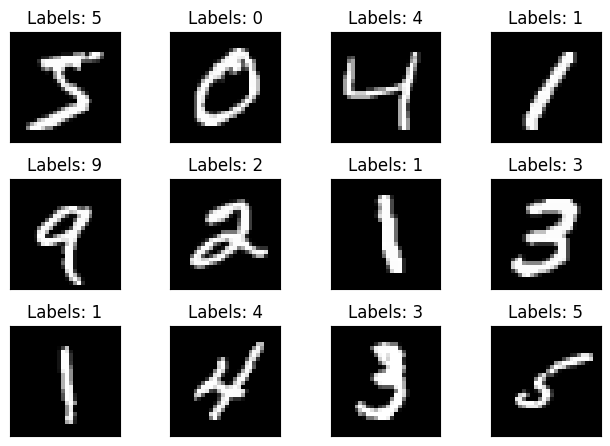

In [4]:
# 展示数据集
fig = plt.figure()
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.tight_layout()
    plt.imshow(train_dataset.train_data[i], cmap='gray', interpolation='none')
    plt.title("Labels: {}".format(train_dataset.train_labels[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [6]:
# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps"
#     if torch.backends.mps.is_available()
#     else "cpu"
# )

# 虽然 Pytorch 对 苹果的M系列芯片做了优化, 但是如果是低版本的 Pytorch 的话, 建议还是使用 device="cpu"
device = "cuda" # 'cpu'
print(f"Using {device} device")

Using cuda device


In [7]:
# 参数量减少的 LeNet 

class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5)   
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=3 * 12 * 12, out_features=num_classes)   

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))

        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        
        return x
    
model = LeNet().to(device=device)

In [11]:
def train(
  model: nn.Module,
  dataloader: DataLoader,
  criterion: nn.Module,
  optimizer: Optimizer,
  callbacks = None
) -> None:
  model.train()

  for inputs, targets in tqdm(dataloader, desc='train', leave=False):
    inputs = inputs.to(device)
    targets = targets
    # print(inputs.shape)
    # Reset the gradients (from the last iteration)
    optimizer.zero_grad()

    # Forward inference
    outputs = model(inputs).cpu()
    loss = criterion(outputs, targets)

    # Backward propagation
    loss.backward()

    # Update optimizer 
    optimizer.step()

    if callbacks is not None:
        for callback in callbacks:
            callback()

In [14]:
@torch.inference_mode()
def evaluate(
  model: nn.Module,
  dataloader: DataLoader,
  verbose=True,
) -> float:
  model.eval()

  num_samples = 0
  num_correct = 0

  for inputs, targets in tqdm(dataloader, desc="eval", leave=False,
                              disable=not verbose):
    inputs = inputs.to(device)
    targets = targets
  
    # Inference
    outputs = model(inputs).cpu()

    # Convert logits to class indices
    outputs = outputs.argmax(dim=1)

    # Update metrics
    num_samples += targets.size(0)
    num_correct += (outputs == targets).sum()

  return (num_correct / num_samples * 100).item()

In [15]:
lr = 0.01
momentum = 0.5
num_epoch = 5

optimizer = torch.optim.SGD(model.parameters(),  lr=lr, momentum=momentum)  # lr学习率，momentum冲量
criterion = nn.CrossEntropyLoss()  # 交叉熵损失


best_accuracy = 0
best_checkpoint = dict()

for epoch in range(num_epoch):
    train(model, train_loader, criterion, optimizer)
    accuracy = evaluate(model, test_loader)
    is_best = accuracy > best_accuracy
    if is_best:
        best_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy

    print(f'Epoch{epoch+1:>2d} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')


torch.save(best_checkpoint['state_dict'], './checkpoints/student.pt')

train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1 Accuracy 76.51% / Best Accuracy: 76.51%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2 Accuracy 76.74% / Best Accuracy: 76.74%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3 Accuracy 77.21% / Best Accuracy: 77.21%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4 Accuracy 77.03% / Best Accuracy: 77.21%


train:   0%|          | 0/938 [00:00<?, ?it/s]

eval:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5 Accuracy 77.52% / Best Accuracy: 77.52%


In [16]:
model_accuracy = evaluate(model, test_loader)
print(f"Model has accuracy={model_accuracy:.2f}%")

eval:   0%|          | 0/157 [00:00<?, ?it/s]

Model has accuracy=77.52%
